In [1]:
# Load dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
pd.options.display.float_format = '{:,.1e}'.format
from scipy.stats import gmean
import sys
sys.path.insert(0, '../../../statistics_helper')
from CI_helper import *
from excel_utils import *

# Estimating the biomass of fish
To estimate the biomass of fish, we first estimate the total biomass of mesopelagic fish, and then add to this estimate the estmimate for the non-mesopelagic fish made by [Wilson et al.](http://dx.doi.org/10.1126/science.1157972). 

In order to estimate the biomass of mesopelagic fish, we rely on two independent methods - and estimate based on trawling by [Lam & Pauly](http://www.seaaroundus.org/doc/Researcher+Publications/dpauly/PDF/2005/OtherItems/MappingGlobalBiomassMesopelagicFishes.pdf), and an estimate based on sonar.

## Sonar-based estimate
We generate the sonar-based estimate relying on data from [Irigoien et al.](http://dx.doi.org/10.1038/ncomms4271) and [Proud et al.](http://dx.doi.org/10.1016/j.cub.2016.11.003).

Estimating the biomass of mesopelagic fish using sonar is a two step process. First we use estimates of the global backscatter of mesopelagic fish. This backscatter is converted to an estimate of the global biomass of mesopelagic fish by using estimates for the target strength of a single mesopelagic fish.

### Total backscatter
To estimate the total backscatter of mesopelagic fish, we rely on [Irigoien et al.](http://dx.doi.org/10.1038/ncomms4271) and [Proud et al.](http://dx.doi.org/10.1016/j.cub.2016.11.003). Irigoien et al. generates several different estimates for the global  nautical area scatter of mesopelagic fish. We use the geometric mean of the estimates of Irigoien et al. as one source for estimating the total backscatter of mesopelagic fish. We note that the units used by Irigoien et al. are incorrect, as nautical area scatteing coefficient (NASC) is measured in $\frac{m^2}{nm^2}$, but the order of magnitude of the values estimated by Irigoien et al. implies that they multiplied the NASC by the surface area of the ocean in units of $m^2$. This means that the values reported by Irigoien et al. are in fact in units of $\frac{m^4}{nm^2}$. We convert the values reported by Irigoein et al. from the total scatter to the total backscatter by using the equation: $$global \: backscatter \: [m^2] = \frac{global \: scatter \: [\frac{m^4}{nmi^2}]}{4\pi×\frac{1852^2 m^2}{nmi^2}}$$ 

In [2]:
# Load scatter data from Irigoien et al.
scatter = pd.read_excel('fish_biomass_data.xlsx', 'Total scatter',skiprows=1)

# convert scater to backscatter
scatter['Total backscatter [m^2]'] = scatter['Total sA [m^4 nmi^-2]']/(4*np.pi*1852**2)
scatter['Total sA [m^4 nmi^-2]'] = scatter['Total sA [m^4 nmi^-2]'].astype(float)
scatter

sA estimate  Total sA [m^4 nmi^-2]  \
0                   OLS: sA = 2384.4* ln(PP) – 11678                4.2e+17   
1                 OLS: ln (sA) = 1.52* ln(PP) – 1.36                4.7e+17   
2                   GWR: ln(sA) = 1.36*ln (PP) – 0.2                5.6e+17   
3  GWR different equations for PP above and below...                4.4e+17   
4  Cruise average sA  × ocean surface deeper than...                4.1e+17   

   Total backscatter [m^2]  
0                  9.8e+09  
1                  1.1e+10  
2                  1.3e+10  
3                  1.0e+10  
4                  9.6e+09

In [3]:
# Calculate the geometric mean of values from Irigoien et al.
irigoien_backscatter = gmean(scatter['Total backscatter [m^2]'])
print('The geometric mean of global backscatter from Irigoien et al. is ≈%.1e m^2' %irigoien_backscatter)

The geometric mean of global backscatter from Irigoien et al. is ≈1.1e+10 m^2


As our best estimate for the global backscatter of mesopelagic fish, we use the geometric mean of the average value from Irigoien et al. and the value reported in Proud et al.

In [4]:
# The global backscatter reported by Proud et al.
proud_backscatter = 6.02e9

# Our best estimate 
best_backscatter = gmean([irigoien_backscatter,proud_backscatter])
print('Our best estimate for the global backscatter of mesapelagic fish is %.0e m^2' %best_backscatter)

Our best estimate for the global backscatter of mesapelagic fish is 8e+09 m^2


### Target strength
In order to convert the global backscatter into biomass, we use reported values for the target strength per unit biomass of mesopelagic fish. The target strength is a measure of the the backscattering cross-section in dB, which is defined as $TS = 10 \times log_{10}(\sigma_{bs})$ with units of dB 1 re $m^2$. By measuring the relation between the target strength and biomass of mesopelagic fish, one can calculate the target strength per unit biomass in units of db 1 re $\frac{m^2}{kg}$. We can use the global backscatter to calculate the total biomass of mesopelagic fish based on the equation provided in [MacLennan et al.](https://doi.org/10.1006/jmsc.2001.1158): $$biomass_{fish} \:[kg]= \frac{global \: backscatter \: [m^2]}{10^{\frac{TS_{kg}}{10}} [m^2 kg^{-1}]}$$
Where $TS_{kg}$ is the terget strength per kilogram biomass.

The main source affecting the target strength of mesopelagic fish is their swimbaldder, as the swimbladder serves as a strong acoustic reflector at the frequencies used to measure the backscattering of mesopelagic fish. Irigoien et al. provide a list of values from the literature of target strength per unit biomass for mesopelagic fish with or without swimbladder. It is clear from the data that the presence or absence of swimbladder segregates the data into two distinct groups:

Text(0,0.5,'Counts')

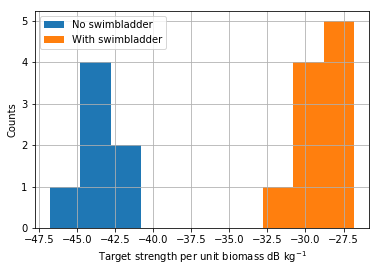

In [5]:
# Load terget strength data
ts = pd.read_excel('fish_biomass_data.xlsx', 'Target strength')

# Plot the distribution of TS for fish with or without swimbladder
ts[ts['Swimbladder']=='No']['dB kg^-1'].hist(label='No swimbladder', bins=3)
ts[ts['Swimbladder']=='Yes']['dB kg^-1'].hist(label='With swimbladder', bins=3)
plt.legend()
plt.xlabel(r'Target strength per unit biomass dB kg$^{-1}$')
plt.ylabel('Counts')

To estimate the characteristic target strength per unit biomass of mesopelagic fish, we first estiamte the characteristic target strength per unit biomass of fish with or without swimbladder. We assume that fish with and without swimbladder represent an equal portion of the population of mesopelagic fish. We test the uncertainty associated with this assumption in the uncertainty analysis section.

In [6]:
# Calculate the average TS per kg for fish with and without swimbladder
TS_bin = ts.groupby('Swimbladder').mean()
TS_bin['dB kg^-1']

Swimbladder
No    -4.3e+01
Yes   -2.9e+01
Name: dB kg^-1, dtype: float64

We use our best estimate for the target strength per unit biomass to estimate the total biomass of mesopelagic fish. We transform the TS to backscattering cross-section, and then calculate the effective population backscattering cross-section based on the assumption that fish with or without swimbladder represent equal portions of the population.

In [7]:
# The conversion equation from global backscatter and terget strength per unit biomass
biomass_estimator = lambda TS1,TS2,bs,frac: bs/(frac*10**(TS1/10.) + (1.-frac)*10**(TS2/10.))

# Estimate biomass and convert to g C, assuming fish with or without swimbladder are both 50% of the population
sonar_biomass = biomass_estimator(*TS_bin['dB kg^-1'],best_backscatter,frac=0.5)*1000*0.15
print('Our best sonar-based estimate for the biomass of mesopelagic fish is ≈%.1f Gt C' %(sonar_biomass/1e15))

Our best sonar-based estimate for the biomass of mesopelagic fish is ≈1.8 Gt C


As noted in the Supplementary Information, there are several caveats which might bias the results. We use the geometric mean of estimates based on sonar and earlier estimates based on trawling to generate a robust estimate for the biomass of mesopelagic fish.

In [8]:
# The estimate of the global biomass of mesopelagic fish based on trawling reported in Lan & Pauly
trawling_biomass = 1.5e14

# Estimate the biomass of mesopelagic fish based on the geometric mean of sonar-based and trawling-based estimates
best_mesopelagic_biomass = gmean([sonar_biomass,trawling_biomass])
print('Our best estimate for the biomass of mesopelagic fish is ≈%.1f Gt C' %(best_mesopelagic_biomass/1e15))

Our best estimate for the biomass of mesopelagic fish is ≈0.5 Gt C


Finally, we add to our estimate of the biomass of mesopelagic fish the estimate of biomass of non-mesopelagic fish made by [Wilson et al.](http://dx.doi.org/10.1126/science.1157972) to generate our estimate for the total biomass of fish.

In [9]:
# The estimate of non-mesopelagic fish based on Wilson et al.
non_mesopelagic_fish_biomass = 1.5e14

best_estimate = best_mesopelagic_biomass+non_mesopelagic_fish_biomass
print('Our best estimate for the biomass of fish is ≈%.1f Gt C' %(best_estimate/1e15))

Our best estimate for the biomass of fish is ≈0.7 Gt C


# Uncertainty analysis
In order to assess the uncertainty associated with our estimate for the biomass of fish, we assess the uncertainty associated with the sonar-based estimate of the biomass of mesopelagic fish, as well as for the non-mesopelagic fish biomass.

## Mesopelagic fish uncertainty
To quantify the uncertainty associated with our estimate of the biomass of mesopelagic fish, we assess the uncertainty associated with the sonar-based estimate, and the inter-method uncertainty between the sonar-based and trawling-based estimates. We do not assess the uncertainty of the trawling-based estimate as no data regarding the uncertainty of the estimate is available.

### Sonar-based estimate uncertainty
The main parameters influencing the uncertainty of the sonar-based estimates are the global backscatter and the characteristic target-strength per unit biomass. We calculate the uncertainty associated with each one of those parameters, and them combine these uncertainties to quantify the uncertainty of the sonar-based estimate.

#### Global Backscatter
For calculating the global backscatter, we rely in two sources of data - Data from Irigoien et al. and data from Proud et al. We survery both the intra-study uncertainty and interstudy uncertainty associated with the global backscatter.

##### Intra-study uncertainty
Irigoien et al. provides several estimates for the global scatter based on several different types of equations characterizing the relationship between primary productivity and the NASC. We calculate the 95% confidence interval of the geometric mean of these different estimates.

Proud et al. estimate a global backscatter of 6.02×$10^9$ $m^2$ ± 1.4×$10^9$ $m^2$. We thus use this range as a measure of the intra-study uncertainty in the estimate of Proud et al.


In [10]:
# Calculate the intra-study uncertainty of Irigoien et al.
irigoien_CI = geo_CI_calc(scatter['Total backscatter [m^2]'])

# Calculate the intra-study uncertainty of Proud et al.
proud_CI = (1.4e9+6.02e9)/6.02e9

print('The intra-study uncertainty of the total backscatter estimate of Irigoien et al. is ≈%.1f-fold' %irigoien_CI)
print('The intra-study uncertainty of the total backscatter estimate of Proud et al. is ≈%.1f-fold' %proud_CI)

The intra-study uncertainty of the total backscatter estimate of Irigoien et al. is ≈1.1-fold
The intra-study uncertainty of the total backscatter estimate of Proud et al. is ≈1.2-fold


##### Interstudy uncertainty
As a measure of the interstudy uncertainty of the global backscatter, we calculate the 95% confidence interval of the geometric mean of the estimate from Irigoien et al. and Proud et al.:

In [11]:
# Calculate the interstudy uncertainty of the global backscatter
bs_inter_CI = geo_CI_calc([irigoien_backscatter,proud_backscatter])

print('The interstudy uncertainty of the total backscatter  is ≈%.1f-fold' %bs_inter_CI)

# Take the highest uncertainty as our best projection of the uncertainty associates with the global backscatter
bs_CI = np.max([irigoien_CI,proud_CI,bs_inter_CI])

The interstudy uncertainty of the total backscatter  is ≈1.7-fold


We use the highest uncertainty among these different kinds of uncertainty measures as our best projection of the uncertainty of the global backscatter, which is ≈1.7-fold.

#### Target strength per unit biomass
To assess the uncertainty associated with the target strength per unit biomass, we calculate the uncertainty in estimating the characteristic target strength per unit biomass of fish with or without swimbladders, adn the uncertainty associated with the fraction of the population that either has or lacks swimbladder

##### Uncertainty of characteristic target strength per unit biomass of fish with or without swimbladder
We calculate the 95% confidence interval of the target strength of fish with or withour swimbladder, and propagate this confidence interval to the total estimate of biomass to assess the uncertainty associated with the estimate of the target strength. We calculated an uncertainty of ≈1.3-fold. associated with te estimate of the target strength per unit biomass of fish.

In [12]:
# Define the function that will estimate the 95% confidence interval
def CI_groupby(input):
    return input['dB kg^-1'].std(ddof=1)/np.sqrt(input['dB kg^-1'].shape[0])

# Group target strength values by the presence of absence of swimbladder
ts_bin = ts.groupby('Swimbladder')

# Calculate sandard error of those values
ts_bin_CI = ts_bin.apply(CI_groupby)
ts_CI = []

# For the target strength of fish with or without swimbladder, sample 1000 times from the distribution
# of target strengths, and calculate the estimate of the total biomass of fish. Then calcualte the 95%
# confidence interval of the resulting distribution as a measure of the uncertainty in the biomass 
# estimate resulting from the uncertainty in the target strength

for x, instance in enumerate(ts_bin_CI):
    ts_dist = np.random.normal(TS_bin['dB kg^-1'][x],instance,1000)
    biomass_dist = biomass_estimator(ts_dist,TS_bin['dB kg^-1'][1-x],best_backscatter,frac=0.5)*1000*0.15
    upper_CI = np.percentile(biomass_dist,97.5)/np.mean(biomass_dist)
    lower_CI = np.mean(biomass_dist)/np.percentile(biomass_dist,2.5)
    ts_CI.append(np.mean([upper_CI,lower_CI]))
# Take the maximum uncertainty of the with or with out swimbladder as our best projection
ts_CI = np.max(ts_CI)
print('Our best projection for the uncertainty associated with the estimate of the target strength per unit biomass is ≈%.1f-fold' %ts_CI)

Our best projection for the uncertainty associated with the estimate of the target strength per unit biomass is ≈1.3-fold


##### Uncertainty of the fraction of the population possessing swimbladder
As a measure of the uncertainty associated with the assumption that fish with or without swimbladder contributed similar portions to the total population of mesopelagic fish, we sample different ratios of fish with and without swimbladder, and calculate the biomass estimate for those fractions.

Text(0,0.5,'Biomass estimate [Gt C]')

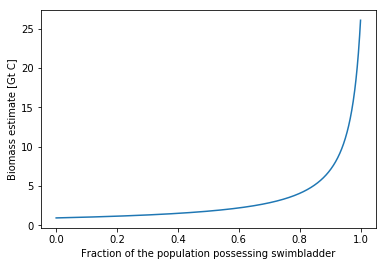

In [13]:
# Sample different fractions of fish with swimbladder
ratio_range = np.linspace(0,1,1000)

# Estiamte the biomass of mesopelagic fish using the sampled fraction
biomass_ratio_dist = biomass_estimator(*TS_bin['dB kg^-1'],best_backscatter,ratio_range)*1000*0.15/1e15

# Plot the results for all fractions
plt.plot(ratio_range,biomass_ratio_dist)
plt.xlabel('Fraction of the population possessing swimbladder')
plt.ylabel('Biomass estimate [Gt C]')

We take the 95% range of distribution of fraction of fish with swimbladder account and calculate the uncertainty this fraction introduces into the sonar-based estimate of mesopelagic fish biomass. In this range the confidence interval of the biomass estimate is ≈8.7-fold.

In [14]:
# Calculate the upper and lower bounds of the influence of the fraction of fish with swimbladder on biomass estimate
ratio_upper_CI = (biomass_estimator(*TS_bin['dB kg^-1'],best_backscatter,0.975)*1000*0.15)/sonar_biomass
ratio_lower_CI = sonar_biomass/(biomass_estimator(*TS_bin['dB kg^-1'],best_backscatter,0)*1000*0.15)
ratio_CI = np.max([ratio_upper_CI,ratio_lower_CI])
print('Our best projection for the uncertainty associated with the fraction of fish possessing swimbladder is ≈%.1f-fold' %ratio_CI)

Our best projection for the uncertainty associated with the fraction of fish possessing swimbladder is ≈8.7-fold


To calculate the total uncertainty associated with the sonar-based estimate, we propagate the uncertainties associated with the total backscatter, the target strength per unit biomass and the fraction of fish with swimbladder.


In [15]:
sonar_CI = CI_prod_prop(np.array([ratio_CI,ts_CI,bs_CI]))
print('Our best projection for the uncertainty associated with the sonar-based estimate for the biomass of mesopelagic fish is ≈%.1f-fold' %sonar_CI)

Our best projection for the uncertainty associated with the sonar-based estimate for the biomass of mesopelagic fish is ≈9.5-fold


### Inter-method uncertainty
As a measure of the inter-method uncertainty of our estimate of the biomass of mesopelagic fish, we calculate the 95% confidence interval of the geometric mean of the sonar-based estiamte and the trawling-based estimate.

In [16]:
meso_inter_CI = geo_CI_calc(np.array([sonar_biomass,trawling_biomass]))
print('Our best projection for the inter method uncertainty associated with estimate of the biomass of mesopelagic fish is ≈%.1f-fold' %meso_inter_CI)

# Take the highest uncertainty as our best projection for the uncertainty associated with the estimate
# of the biomass of mesopelagic fish
meso_CI = np.max([meso_inter_CI,sonar_CI])

Our best projection for the inter method uncertainty associated with estimate of the biomass of mesopelagic fish is ≈11.3-fold


Comparing our projections for the uncertainty of the sonar-based estimate of the biomass of mesopelagic fish and the inter-method uncertainty, our best projection for the biomass of mesopelagic fish is about one order of magnitude.

## Non-mesopelagic fish biomass uncertainty
For estimating the biomass of non-mesopelagic fish, we rely on estimates by Wilson et al., which does not report an uncertainty range for the biomass of non-meso pelagic fish. A later study ([Jennings et al.](https://doi.org/10.1371/journal.pone.0133794), gave an estimate for the total biomass of fish with body weight of 1 g to 1000 kg, based on ecological models. Jenning et al. reports a 90% confidence interval of 0.34-26.12 Gt wet weight, with a median estimate of ≈5 Gt wet weight. We take this range as a crude measure of the uncertainty associated with the estimate of the biomass of non-mesopelagic fish.

In [17]:
# Calculate the uncertainty of the non-mesopelagic fish biomass
non_meso_CI = np.max([26.12/5,5/0.34])

# Propagate the uncertainties of mesopelagic fish biomass and non-mesopelagic fish biomass to the total estimate
# of fish biomass
mul_CI = CI_sum_prop(estimates=np.array([best_mesopelagic_biomass,non_mesopelagic_fish_biomass]), mul_CIs=np.array([meso_CI,non_meso_CI]))
print('Our best projection for the uncertainty associated with the estimate of the biomass of fish is ≈%.1f-fold' %mul_CI)

Our best projection for the uncertainty associated with the estimate of the biomass of fish is ≈8.3-fold


# Prehuman fish biomass
To estimate the prehuman fish biomass, we rely on a study ([](http://dx.doi.org/10.1073/pnas.1520420113)) which states that fish stocks in global fisheries are 1.17 of the Maximal Sustainable Yield biomass, when looking at all fisheries and calculating a catch-weighted average global fishery (Figure S12 in the SI Appendix of Costello et al.). Costello et al. also reports the total biomass of present day fisheries at 0.84 Gt wet weight (Table S15 in the SI Appendix of Costello et al.). Assuming 70% water content and 50% carbon content out of wet weight, this translates to:

In [18]:
costello_ww = 0.84
wet_to_c = 0.3*0.5
costello_cc = costello_ww*wet_to_c
print('Costello et al. estimate ≈%.2f Gt C of current fisheries' %costello_cc)

Costello et al. estimate ≈0.13 Gt C of current fisheries


This number is close to the number reported by Wilson et al. Using a database of published landings data and stock assessment biomass estimates, [Thorson et al.](http://dx.doi.org/10.1139/f2012-077) estimate that the biomass of fish at the maximum sustainable yield represent ≈40% of the biomass the population would have reached in case of no fishing. From these two numbers, we can estimate the prehuamn biomass of fish in fisheries. We use the total biomass of fisheries reported in Costello et al., divide it the bte ratio reported in Costello et al. to estimate the Maximal Sustainable Yield biomass, and then divide this number by 0.4 to arrive at the prehuman biomass of fish in fisheries. We add to this estimate the estimate of the total biomass of mesopelagic fish, assuming their biomass wasn't affected by humans.

In [19]:
costello_ratio = 1.17
thorson_ratio = 0.4
prehuman_biomass_fisheries = costello_cc*1e15/costello_ratio/thorson_ratio
prehuman_fish_biomass = prehuman_biomass_fisheries+best_mesopelagic_biomass
print('Our estimate for the total prehuman biomass of fish is ≈%.1f Gt C' %(prehuman_fish_biomass/1e15))

Our estimate for the total prehuman biomass of fish is ≈0.8 Gt C


Comparing the prehuman fish biomass to the present day fish biomass, we can estimate the human associated reduction in fish biomass:

In [20]:
fish_biomass_decrease = prehuman_fish_biomass-best_estimate
print('Our estimate for the decrease in the total biomass of fish is ≈%.2f Gt C' %(fish_biomass_decrease/1e15))

Our estimate for the decrease in the total biomass of fish is ≈0.12 Gt C


# Estimating the total number of fish
To estimate the total number of fish, we divide our estimate of the total biomass of mesopelagic fish by an estimate for the characteristic carbon content of a single mesopelagic fish. 
To estimate the mean weight of mesopelagic fish, we rely on data reported in [Fock & Ehrich](https://doi.org/10.1111/j.1439-0426.2010.01450.x) for the family Myctophidae (Lanternfish), which dominate the mesopelagic fish species. Fock & Ehrich report the length range of each fish species, as well as allometric relations between fish length and weight for each species. Here is a sample of the data:

In [21]:
# Load the data from Fock & Ehrich
fe_data = pd.read_excel('fish_biomass_data.xlsx','Fock & Ehrich', skiprows=1)

# Use only data for the Myctophidae family
fe_mycto = fe_data[fe_data['Family'] == 'Myctophidae']

fe_mycto.head()

Family           Genus         Species   a(SL)   b(SL)  \
95  Myctophidae      Benthosema        glaciale 1.0e-02 3.0e+00   
96  Myctophidae      Benthosema     suborbitale 1.0e-02 3.0e+00   
97  Myctophidae    Bolinichthys         indicus 1.3e-02 2.9e+00   
98  Myctophidae    Bolinichthys  supralateralis 7.5e-03 3.2e+00   
99  Myctophidae  Ceratoscopelus      maderensis 6.8e-03 3.2e+00   

    Calculation method Minimum length (mm) Maximum length (mm)  \
95             3.0e+00                  21                  81   
96             6.0e+00                  37                  37   
97             3.0e+00                  31                  46   
98             3.0e+00                  42                 107   
99             3.0e+00                  27                  85   

   1982 deviation statistic dj 1982 wj-bjregression slope  \
95                     1.8e+02                    4.2e-01   
96                                                          
97                     1.0e+03                    8.0e-02   
98                     3.3e+01                    1.9e+00   
99                     6.1e+02                    1.3e-01   

   1982 sample size for regression (n=) 1983 deviation statistic dj  \
95                                    5                     3.4e+01   
96                                                                    
97                                    3                               
98                                    7                               
99                                    8                     1.5e+01   

   1983 wj-bjregression slope 1983 sample size for regression (n=) Remarks  
95                    8.9e-01                                   16          
96                                                                          
97                                                                          
98                                                                          
99                    7.7e-01                                    2

The allometric parameters a and b are plugged into the following equation to produce the weight of each fish species based on the length of each fish: $$ W = a*L^b$$
Where W is the fish weight and L is the fish length. For each fish species, we calculate the characteristic fish length by using the mean of the minimum and maximum reported fish lengths:

In [22]:
fe_mean_length = np.mean([fe_mycto['Maximum length (mm)'].astype(float),fe_mycto['Minimum length (mm)'].astype(float)])

We plug the mean length of each fish species into the allometric equation along with its specific parameters a and b to generate the mean wet weight of each fish. We use the geometric mean of the weights of all species as our best estimate of the weight of a single mesopelagic fish. We convert wet weight to carbon mass assuming 70% water content and 50% carbon our of the dry weight.

In [23]:
# The allometric equation to convert fish length into fish weight. The equation takes values
# in cm and the data is given in mm so we divide the length by a factor of 10
calculate_weight = lambda x,a,b: a*(x/10)**b

# Transform the mean lengths of each fish species into a characteristic weight of each fish species
fe_mean_weight = calculate_weight(fe_mean_length,fe_mycto['a(SL)'],fe_mycto['b(SL)'])

# Conversion factor from wet weight to carbon mass
wet_to_c = 0.15

# Calculate the mean carbon content of a single mesopelagic fish
fish_cc = gmean(fe_mean_weight.astype(float))*wet_to_c

print('Our best estimate for the carbon content of a single mesopelagic fish is ≈%.2f g C' %fish_cc)

Our best estimate for the carbon content of a single mesopelagic fish is ≈0.46 g C


We estimate the total number of mesopelagic fish by dividing our best estimate for the total biomass of mesopelagic fish by our estimate for the carbon content of a single mesopelagic fish:

In [24]:
# Estimate the total number of fish
tot_fish_num = best_mesopelagic_biomass/fish_cc

print('Our best estimate for the total number of individual fish is ≈%.0e.' %tot_fish_num)

Our best estimate for the total number of individual fish is ≈1e+15.


In [25]:
# Feed results to the chordate biomass data
old_results = pd.read_excel('../../animal_biomass_estimate.xlsx',index_col=0)
result = old_results.copy()
result.loc['Fish',(['Biomass [Gt C]','Uncertainty'])] = (best_estimate/1e15,mul_CI)
result.to_excel('../../animal_biomass_estimate.xlsx')

# Feed results to Table 1 & Fig. 1
update_results(sheet='Table1 & Fig1', 
               row=('Animals','Fish'), 
               col=['Biomass [Gt C]', 'Uncertainty'],
               values=[best_estimate/1e15,mul_CI],
               path='../../../results.xlsx')


# Feed results to Table S1
update_results(sheet='Table S1', 
               row=('Animals','Fish'), 
               col=['Number of individuals'],
               values=tot_fish_num,
               path='../../../results.xlsx')

# Update the data mentioned in the MS
update_MS_data(row ='Decrease in biomass of fish',
               values=fish_biomass_decrease/1e15,
               path='../../../results.xlsx')